In [1]:
import torch
from ptbxlae.modeling.singleCycleConv import SingleCycleConvVAE
from ptbxlae.dataprocessing.cachedDS import SingleCycleCachedDS
import matplotlib.pyplot as plt


* PTB-XL Autoencoder *


In [2]:
torch.no_grad()
m = SingleCycleConvVAE.load_from_checkpoint('../cache/savedmodels/last-v1.ckpt')
m = m.eval()
m

/home/isears/VirtualEnvironments/default/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


SingleCycleConvVAE(
  (encoder): Sequential(
    (0): Conv1d(12, 24, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(24, 48, kernel_size=(5,), stride=(2,), padding=(2,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mean): Linear(in_features=6000, out_features=25, bias=True)
  (fc_logvar): Linear(in_features=6000, out_features=25, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=1200, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(48, 25))
    (2): Upsample(scale_factor=4.0, mode='nearest')
    (3): ConvTranspose1d(48, 24, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Upsample(scale_factor=5.0, mode='nearest')
    (7): ConvTranspose1d(24, 12, kernel_size=(5,), stride=(1,), padding=(2,))
  )
)

Text(0.5, 1.0, 'Reconstruction')

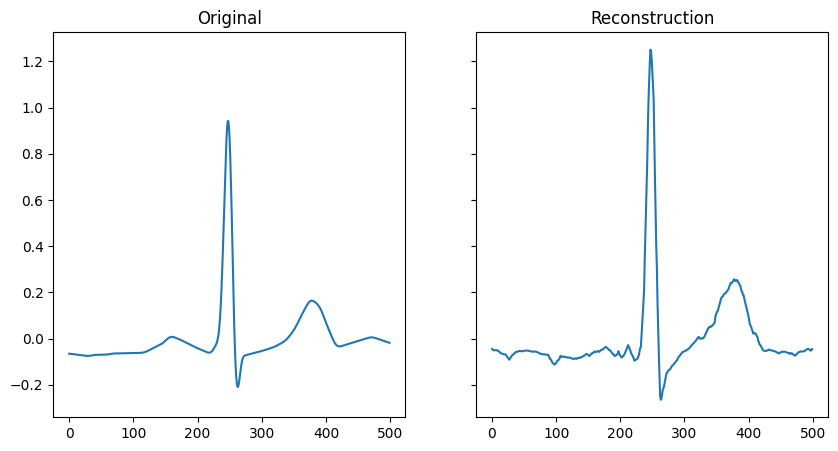

In [3]:
SAMPLE_IDX = 254
CHANNEL = 8
ds = SingleCycleCachedDS(cache_path="../cache/singlecycle_data", randomness=False)

latent_representation = m.encode(ds[SAMPLE_IDX].unsqueeze(0).to('cuda'))
reconstruction = m.decode(latent_representation).squeeze().detach().cpu().numpy()

reconstruction

plt.rcParams['figure.figsize'] = [10, 5]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(range(0, 500), ds[SAMPLE_IDX][CHANNEL])
ax2.plot(range(0, 500), reconstruction[CHANNEL])

ax1.set_title('Original')
ax2.set_title('Reconstruction')

In [4]:
latent_representation

tensor([[ 0.4931,  1.7297,  1.0471,  0.0182, -0.2260, -1.6359, -0.7537, -0.7249,
         -0.3312, -0.5578, -1.0747,  0.4479,  0.1813, -0.6014, -1.8352,  0.1083,
          0.8297, -0.4545, -0.6469,  2.1173, -1.7394, -0.3210,  0.7338,  0.0378,
         -0.7705]], device='cuda:0', grad_fn=<AddBackward0>)

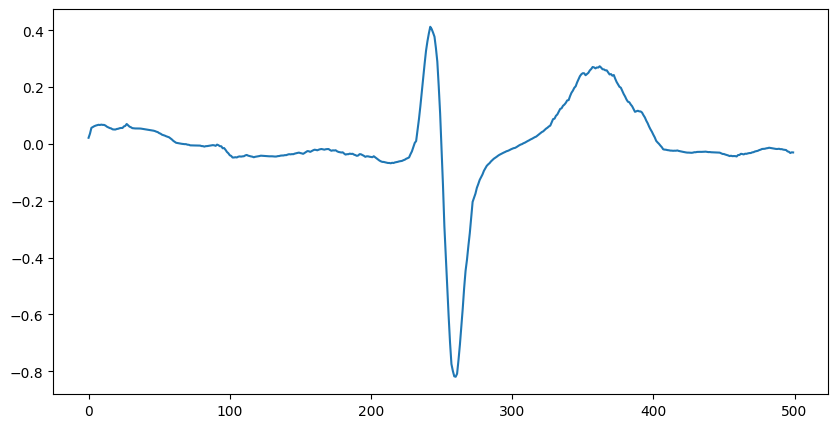

In [5]:
import matplotlib.pyplot as plt

latent = (torch.rand_like(latent_representation) - 0.5) * 2
generated = m.decoder(latent.to('cuda')).squeeze().detach().cpu().numpy()

plt.plot(range(0, generated.shape[-1]), generated[CHANNEL])

interactive(children=(FloatSlider(value=-1.0, description='l', max=1.0, min=-3.0), Output()), _dom_classes=('w…

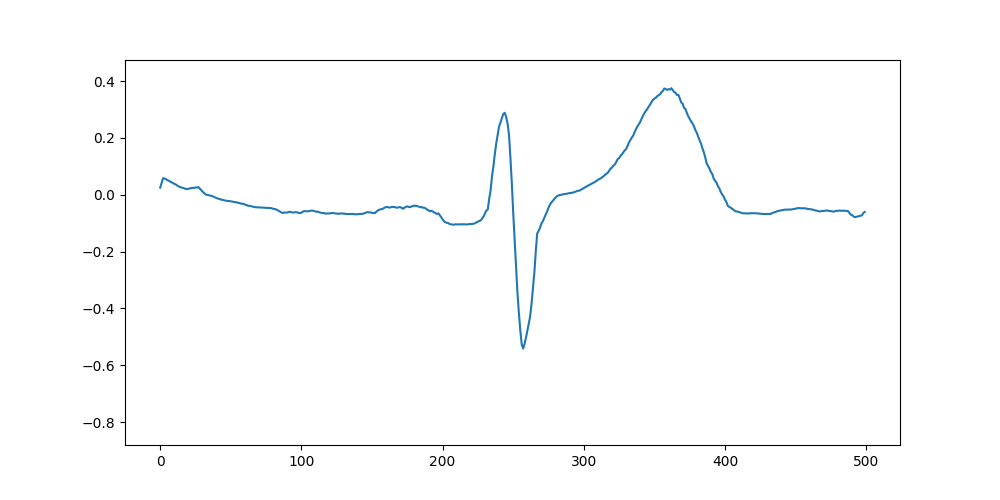

In [7]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


LATENT_FEATURE_IDX = 24
latent = (torch.rand_like(latent_representation) - 0.5) * 2


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(range(0, 500), generated[CHANNEL])

def update(l=-1.0):
    latent[0,LATENT_FEATURE_IDX] = l
    generated = m.decoder(latent.to('cuda')).squeeze().detach().cpu().numpy()
    line.set_ydata(generated[CHANNEL])
    fig.canvas.draw_idle()
    
interact(update);